## Definitions

In [1]:
import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns

# SET PATHS:
# baseDir = '/Volumes/Diedrichsen_data$/data/Chord_exp/EFC_patternfMRI'
baseDir = '/Users/alighavampour/Desktop/Projects/EFC_patternfMRI/data'
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'

## USING RSA SPM OBJECT 

In [14]:
sn = 101
glm = 3
ses = 1
spm = spm_io.SpmGlm(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}'))
spm.get_info_from_spm_mat()
[beta, resMS, reg_info] =  spm.get_betas(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}', 'mask.nii'))


## RAW SIGNALS AND GLM PREDICTIONS

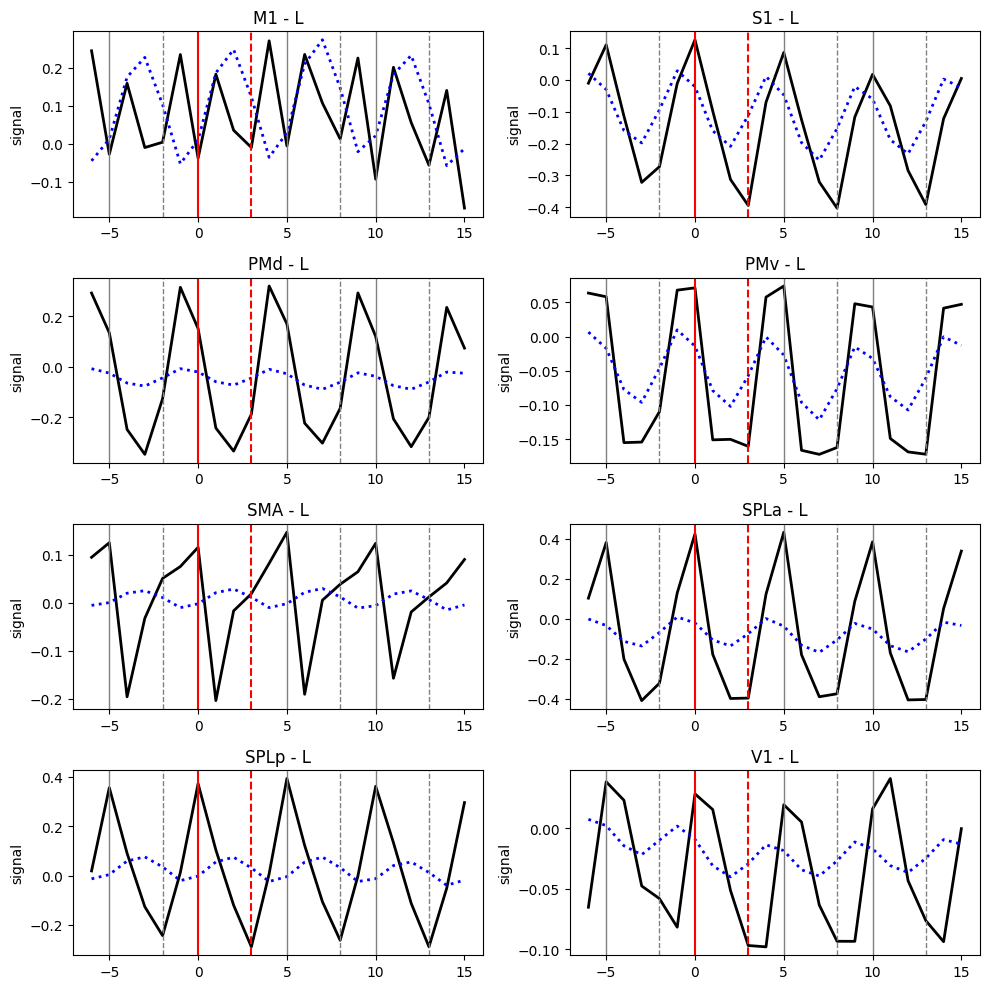

In [3]:
sn = 101
glm = 8
ses = 1
path = os.path.join(baseDir, regDir, f's{sn}', f'ses-{ses:02d}', f'hrf_glm{glm}.mat')
hrf = sio.loadmat(path, simplify_cells=True)['T']
t = np.linspace(-6,15,len(hrf['y_raw'][0]))
Hem = 'L'
roi_names = ['M1', 'S1', 'PMd', 'PMv', 'SMA', 'SPLa', 'SPLp', 'V1']
roi = [3,2,4,5,6,8,9,7]
n_col = 2
n_row = 4
fig, axes = plt.subplots(n_row, n_col, figsize=(10, 10))

for i,r in enumerate(roi):
    # y_adj = np.nanmean(T_dict['y_adj'][((T_dict['name'] == roi[r]) & (T_dict['chordID'] == ch) & (T_dict['hem'] == Hem)).flatten()], axis=0)
    row = (hrf['hem']=='L') & (hrf['region']==r)
    y_raw = np.nanmean(hrf['y_raw'][row], axis=0)
    y_adj = np.nanmean(hrf['y_adj'][row], axis=0)
    y_hat = np.nanmean(hrf['y_hat'][row], axis=0)
    ax = axes[i//n_col, i%n_col]
    ax.plot(t, y_adj, color='k', lw=2)  # Assuming hrf[i] contains the data for the i-th ROI
    ax.plot(t, y_hat, color='b', lw=2, ls=':')
    ax.axvline(-5, color='grey', ls='-', lw=1)
    ax.axvline(-2, color='grey', ls='--', lw=1)
    ax.axvline(0, color='r', ls='-', lw=1.5)
    ax.axvline(3, color='r', ls='--', lw=1.5)
    ax.axvline(5, color='grey', ls='-', lw=1)
    ax.axvline(8, color='grey', ls='--', lw=1)
    ax.axvline(10, color='grey', ls='-', lw=1)
    ax.axvline(13, color='grey', ls='--', lw=1)
    ax.set_title(f'{roi_names[i]} - {Hem}')
    # ax.set_xlabel('Time')
    ax.set_ylabel('signal')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(f'./figures/efpc_Yhat_Yadj_glm{glm}_ses{ses}.pdf', bbox_inches="tight")
plt.show()

## Projection of t-values on surface

In [53]:
sn = 101
glm = 1
ses = 2

spmTs = list(Path(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}')).glob("spmT_*.nii"))
# spmTs = [spmTs[5]]

# 2. Define the relevant gifti files for both left and right hemisphere:
surf_white = [] # White -gray matter surface 
surf_pial = []  # Pial surface 
surf_sulc = []  # Sulcal depth 
hemN = ['L','R']
for h,hem in enumerate(hemN):
    surf_white.append(os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{hem}.white.32k.surf.gii'))
    surf_pial.append(os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{hem}.pial.32k.surf.gii'))
    surf_sulc.append(os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{hem}.sulc.32k.shape.gii'))

# Map a Nifti to the surface of left hemisphere 
DL = surf.map.vol_to_surf(spmTs,surf_pial[0], surf_white[0], excludeThres=0.9)
# Map a Nifti to the surface of right hemisphere 
DR = surf.map.vol_to_surf(spmTs,surf_pial[1],surf_white[1],  excludeThres=0.9)

D = {'L':DL, 'R':DR}

/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_3100/3670302172.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


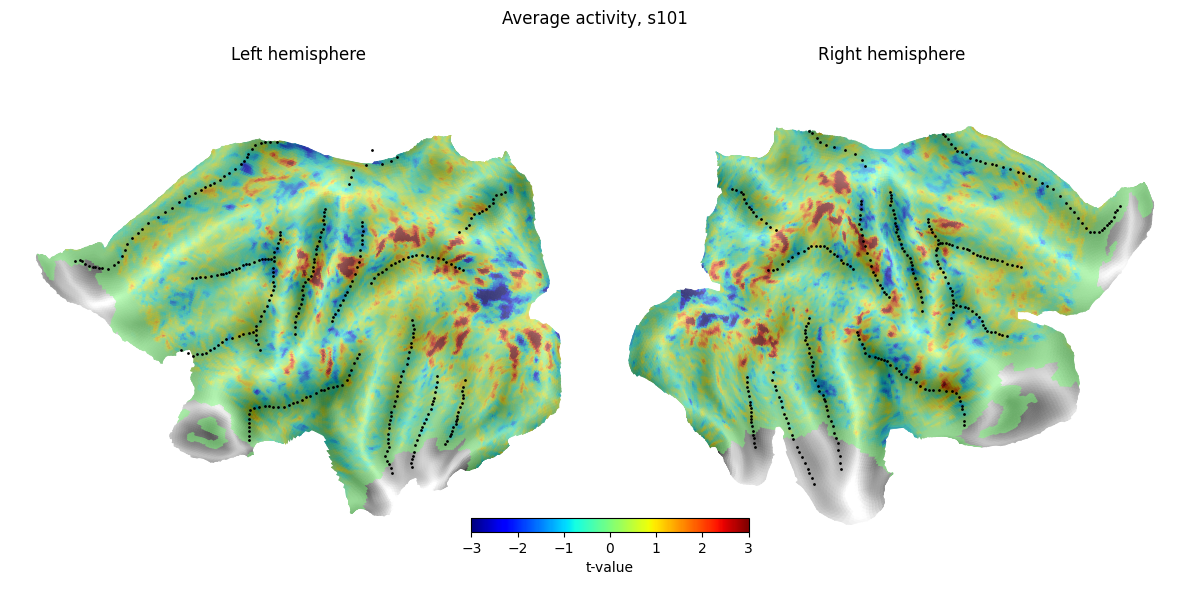

In [54]:
Hem = ['L', 'R']
region_names = ['?', 'S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', '?']
Hem = ['L', 'R']
borders = {'L': './surfAnalysisPy/standard_mesh/fs_L/fs_LR.32k.L.border',
           'R': './surfAnalysisPy/standard_mesh/fs_R/fs_LR.32k.R.border'}

vmin, vmax = -3, 3
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax, H in zip(axs, Hem):
    plt.sca(ax)
    surf.plot.plotmap(D[H].mean(axis=1), f'fs32k_{H}',
                        underlay=None,
                        borders=borders[H],
                        cscale=[vmin, vmax],
                        cmap='jet',
                        underscale=[-1.5, 1],
                        alpha=.5,
                        new_figure=False,
                        colorbar=False,
                        # frame=[xlim[0], xlim[1], ylim[0], ylim[1]]
                        )
# make colorbar
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='jet')
cbar = fig.colorbar(sm, ax=[axs[0], axs[1]], orientation='horizontal', fraction=0.03)
cbar.set_label('t-value')

axs[0].set_title('Left hemisphere')
axs[1].set_title('Right hemisphere')
fig.suptitle(f'Average activity, s{sn}')
fig.tight_layout()
plt.savefig(f'./figures/efcp_spmT2surf_glm{glm}_ses{ses}.pdf', bbox_inches="tight")
